In [2]:
BATCH_SIZE = 128
MAX_LENGTH = 128

# Ensemble Model Run

In this notebook, we will run ensemble models on the segmented data. We will use the following models:
1. Random Forest
2. XGBoost
3. LightGBM

In [3]:
import numpy as np
import pandas as pd

In [4]:
train_labels = (
    pd.read_csv("../../../Datasets/RegExpPURE/PURE_train.csv", usecols=["Req/Not Req"])[
        "Req/Not Req"
    ]
    .map({"Req": 1, "Not_Req": 0})
    .values
)
test_labels = (
    pd.read_csv("../../../Datasets/RegExpPURE/PURE_test.csv", usecols=["Req/Not Req"])[
        "Req/Not Req"
    ]
    .map({"Req": 1, "Not_Req": 0})
    .values
)
valid_labels = (
    pd.read_csv("../../../Datasets/RegExpPURE/PURE_valid.csv", usecols=["Req/Not Req"])[
        "Req/Not Req"
    ]
    .map({"Req": 1, "Not_Req": 0})
    .values
)

In [5]:
train_feature_size = len(train_labels)
test_feature_size = len(test_labels)
valid_feature_size = len(valid_labels)

In [6]:
train_segments = np.concatenate(
    [
        np.load(f"../../../States/Roberta_Pretrained/Train/train_{i}.npy")
        for i in range(0, train_feature_size, BATCH_SIZE)
    ]
)

test_segments = np.concatenate(
    [
        np.load(f"../../../States/Roberta_Pretrained/Test/test_{i}.npy")
        for i in range(0, test_feature_size, BATCH_SIZE)
    ]
)

valid_segments = np.concatenate(
    [
        np.load(f"../../../States/Roberta_Pretrained/Validation/Validation_{i}.npy")
        for i in range(0, valid_feature_size, BATCH_SIZE)
    ]
)

### Pooling
The [cls] token captures the aggregate information of the input sequence and hence it is used for training classifiers. 

In [7]:
cls_token_set_train = train_segments[:, 0, :]
cls_token_set_test = test_segments[:, 0, :]
cls_token_set_valid = valid_segments[:, 0, :]

cls_token_set_train.shape, cls_token_set_test.shape, cls_token_set_valid.shape

((5306, 768), (1534, 768), (905, 768))

In [11]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(cls_token_set_train, train_labels)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy Score:  0.722783289047926


In [14]:
rf_clf_best = RandomForestClassifier(
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_split=grid_search.best_params_["min_samples_split"]
)

rf_clf_best.fit(cls_token_set_train, train_labels)

# Predict the labels of the test set
print("Test set performance:")
print(classification_report(test_labels, rf_clf_best.predict(cls_token_set_test)))

# Predict the labels of the validation set
print("Validation set performance:")
print(classification_report(valid_labels, rf_clf_best.predict(cls_token_set_valid)))

Test set performance:
              precision    recall  f1-score   support

           0       0.53      0.86      0.65       476
           1       0.91      0.65      0.76      1058

    accuracy                           0.72      1534
   macro avg       0.72      0.76      0.71      1534
weighted avg       0.79      0.72      0.73      1534

Validation set performance:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       650
           1       0.54      0.80      0.64       255

    accuracy                           0.75       905
   macro avg       0.72      0.77      0.73       905
weighted avg       0.80      0.75      0.76       905



In [15]:
joblib.dump(
    rf_clf_best,
    "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/RandomForest.joblib",
)

['../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/RandomForest.joblib']

## XGB Classifier

In [28]:
import xgboost as xgb

In [29]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(cls_token_set_train, train_labels)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best Accuracy Score:  0.7376640734410027


In [30]:
# Create an XGBoost classifier with the best hyperparameters
xgb_clf_best = xgb.XGBClassifier(
    max_depth=grid_search.best_params_["max_depth"],
    learning_rate=grid_search.best_params_["learning_rate"],
    n_estimators=grid_search.best_params_["n_estimators"],
    gamma=grid_search.best_params_["gamma"],
    subsample=grid_search.best_params_["subsample"],
    colsample_bytree=grid_search.best_params_["colsample_bytree"],
    random_state=42,
)

# Fit the XGBoost classifier on the training data
xgb_clf_best.fit(cls_token_set_train, train_labels)

# Evaluate the XGBoost classifier on the test set
print("Test Set Performance:")
print(classification_report(test_labels, xgb_clf_best.predict(cls_token_set_test)))

# Evaluate the XGBoost classifier on the validation set
print("Validation Set Performance:")
print(classification_report(valid_labels, xgb_clf_best.predict(cls_token_set_valid)))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.51      0.86      0.64       476
           1       0.91      0.63      0.75      1058

    accuracy                           0.70      1534
   macro avg       0.71      0.75      0.69      1534
weighted avg       0.79      0.70      0.71      1534

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       650
           1       0.55      0.89      0.68       255

    accuracy                           0.77       905
   macro avg       0.75      0.80      0.75       905
weighted avg       0.83      0.77      0.78       905



In [31]:
joblib.dump(
    xgb_clf_best,
    "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/XGBoost.joblib",
)

['../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/XGBoost.joblib']

## LightGBM Classifier

In [20]:
import lightgbm as lgb

In [21]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "num_leaves": [31, 50, 100],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "min_child_samples": [20, 50, 100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# Create a LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(cls_token_set_train, train_labels)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 2832, number of negative: 2474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5306, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533735 -> initscore=0.135147
[LightGBM] [Info] Start training from score 0.135147
Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
Best Accuracy Score:  0.7327662316224434


In [25]:
# Create a LightGBM classifier with the best hyperparameters
lgb_clf_best = lgb.LGBMClassifier(
    num_leaves=grid_search.best_params_["num_leaves"],
    learning_rate=grid_search.best_params_["learning_rate"],
    n_estimators=grid_search.best_params_["n_estimators"],
    min_child_samples=grid_search.best_params_["min_child_samples"],
    subsample=grid_search.best_params_["subsample"],
    colsample_bytree=grid_search.best_params_["colsample_bytree"],
    random_state=42,
)

# Fit the model on the training data
lgb_clf_best.fit(cls_token_set_train, train_labels)

# Evaluate the model on the test set
test_predictions = lgb_clf_best.predict(cls_token_set_test)
print("Test Set Classification Report:")
print(classification_report(test_labels, test_predictions))

# Evaluate the model on the validation set
valid_predictions = lgb_clf_best.predict(cls_token_set_valid)
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_predictions))

[LightGBM] [Info] Number of positive: 2832, number of negative: 2474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5306, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533735 -> initscore=0.135147
[LightGBM] [Info] Start training from score 0.135147
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       476
           1       0.90      0.62      0.74      1058

    accuracy                           0.69      1534
   macro avg       0.70      0.74      0.68      1534
weighted avg       0.78      0.69      0.70      1534

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       650
  

In [26]:
joblib.dump(lgb_clf_best, "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/LightGBM.joblib")

['../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/LightGBM.joblib']

## SVM Classifier

In [16]:
from sklearn.svm import SVC

In [17]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
}

# Create an SVM classifier
svm_clf = SVC(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(cls_token_set_train, train_labels)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy Score:  0.7369161026711467


In [18]:
# Create an SVM classifier with the best hyperparameters
svm_clf_best = SVC(
    C=grid_search.best_params_["C"],
    kernel=grid_search.best_params_["kernel"],
    gamma=grid_search.best_params_["gamma"],
    random_state=42,
)

# Fit the SVM classifier on the training data
svm_clf_best.fit(cls_token_set_train, train_labels)

# Evaluate the SVM classifier on the test set
print("Test Set Performance:")
print(classification_report(test_labels, svm_clf_best.predict(cls_token_set_test)))

# Evaluate the SVM classifier on the validation set
print("Validation Set Performance:")
print(classification_report(valid_labels, svm_clf_best.predict(cls_token_set_valid)))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.55      0.87      0.68       476
           1       0.92      0.68      0.78      1058

    accuracy                           0.74      1534
   macro avg       0.74      0.78      0.73      1534
weighted avg       0.81      0.74      0.75      1534

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.71      0.81       650
           1       0.55      0.92      0.69       255

    accuracy                           0.77       905
   macro avg       0.75      0.81      0.75       905
weighted avg       0.84      0.77      0.78       905



In [19]:
joblib.dump(
    svm_clf_best,
    "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/SVM.joblib",
)

['../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/SVM.joblib']

# ROC AUC Curve

In [1]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## Random Forest

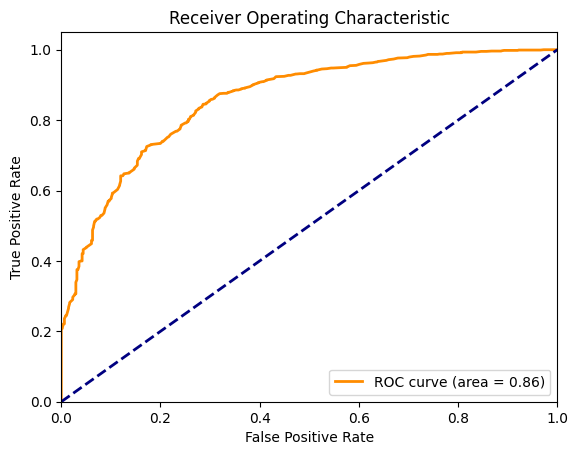

In [14]:
# Load the saved random forest model
rf_clf_best = joblib.load("../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/RandomForest.joblib")

# Predict the probabilities for the positive class
probs = rf_clf_best.predict_proba(cls_token_set_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(test_labels, probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## XGB Classifier

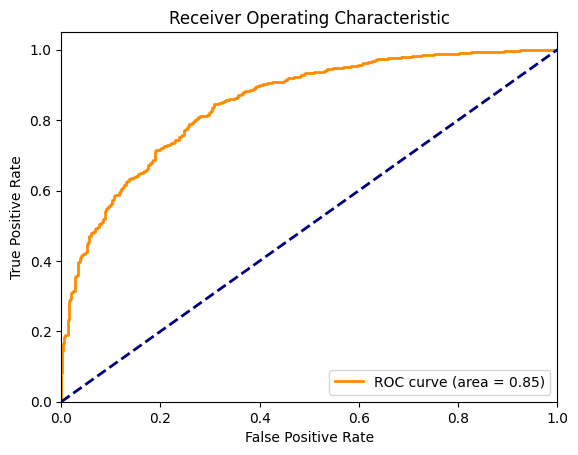

In [15]:
xgb_clf_best = joblib.load(
    "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/XGBoost.joblib"
)

# Predict the probabilities for the positive class
probs = xgb_clf_best.predict_proba(cls_token_set_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(test_labels, probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## LightGBM Classifier

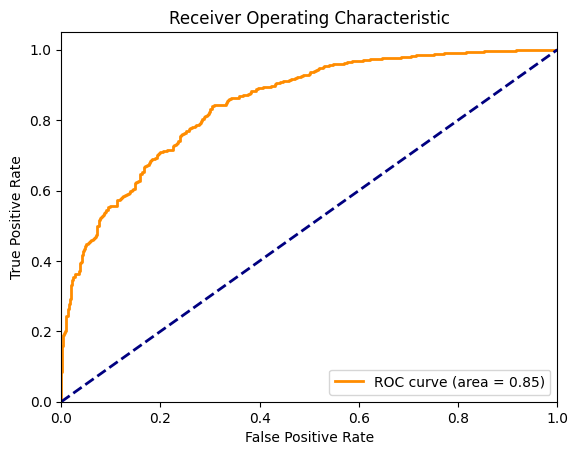

In [16]:
lightgbm_clf_best = joblib.load(
    "../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/LightGBM.joblib"
)

# Predict the probabilities for the positive class
probs = lightgbm_clf_best.predict_proba(cls_token_set_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(test_labels, probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## SVM Classifier

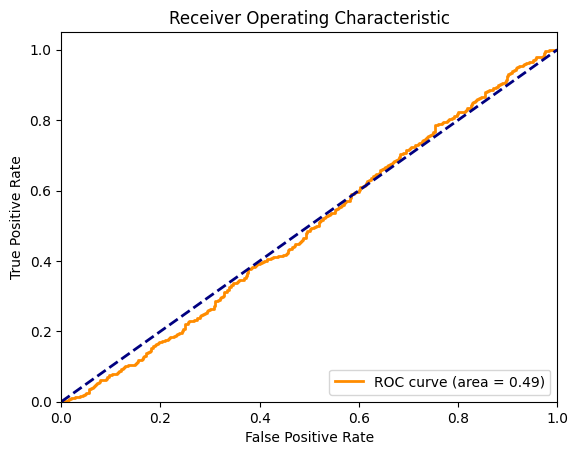

In [19]:
svm_clf_best = joblib.load("../../../Models/RexExpPURE_Classifiers/Roberta_Classifiers/SVM.joblib")

# Predict the decision function scores
scores = svm_clf_best.decision_function(cls_token_set_test)

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(test_labels, scores)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()